<p align="center">
  <span style="font-size: 50px; font-family: 'Arial', sans-serif; color: #2E8B57;">Intel Products Sentiment</span><br>
  <span style="font-size: 35px; font-family: 'Arial', sans-serif; color: #4682B4;">Analysis from Online Reviews</span><br>
  <span style="font-size: 30px; font-family: 'Arial', sans-serif; color: #DA70D6;">Intel Unnati Industrial Training Program 2024</span>
</p>


# Importing Required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import os
import pickle

nltk.download('stopwords')
nltk.download('punkt')

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Exploratory Data Analysis 

Exploring and analyzing the dataset to understand its structure, features, and distributions.

### Dataset Overview

- **Dataset Shape**: The dataset consists of X samples and Y features.
- **Feature Information**: Describe the features present in the dataset and their types (numerical, categorical, etc.).
- **Target Variable Distribution**: Analyze the distribution of the target variable(s) if applicable.

### Summary Statistics

- **Descriptive Statistics**: Provide summary statistics such as mean, median, min, max, and standard deviation for numerical features.

### Data Visualization

- **Histograms and Distributions**: Visualize the distribution of numerical features using histograms.
- **Correlation Heatmap**: Explore the correlations between features using a heatmap to identify potential relationships.

### Insights and Observations

- **Key Findings**: Summarize any key insights or patterns observed during the EDA process.
- **Data Quality**: Note any data quality issues such as missing values or outliers identified.

### Next Steps

- **Feature Engineering**: Outline potential features for further engineering based on insights gained.
- **Preprocessing**: Discuss preprocessing steps such as scaling, encoding, or handling missing values that will prepare the data for modeling.


In [2]:
#Load the data

data = pd.read_csv(r"/kaggle/input/intel-products/intel_processor_reviews.csv", delimiter = ',')
data = data.head(500)
data.head()

,rating,title,text,helpful_vote,verified_purchase
0,2,Works flawlessly! Allows 2 unique displays wit...,UPDATE (from 5 stars to 2 stars): JAN 2023: On...,0,False
1,2,"Doesn't support 2 displays, even for Intel Macs",I am quite disappointed in this dock. It had l...,0,False
2,5,"Laptop Computer, 15.6"" , 8th Gen Intel Core i5...",I've been using this the last 6 weeks and it h...,15,False
3,2,Inspiron i17RV-9909BLK 17.3-Inch Ultrabook 1.8...,I loved it until it died yesterday. I got this...,0,True
4,5,Such an intelligent watch! Incredible!,My wife loves this Amazfit Bip Pro 3 Smart Wat...,2,False


In [3]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['rating' 'title' 'text' 'helpful_vote' 'verified_purchase']


In [4]:
numerical_columns = data.select_dtypes(include=['number']).columns
print(numerical_columns)

Index(['rating', 'helpful_vote'], dtype='object')


In [5]:
data.describe()

,rating,helpful_vote
count,500.000000,500.000000
mean,4.344000,5.458000
std,1.220099,42.958528
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,1.250000
max,5.000000,844.000000


In [6]:
data.isnull().sum()

rating               0
title                0
text                 0
helpful_vote         0
verified_purchase    0
dtype: int64

In [7]:
data.dtypes

rating                int64
title                object
text                 object
helpful_vote          int64
verified_purchase      bool
dtype: object

In [8]:
#exploring the data {Rating}

data['rating'].value_counts()

rating
5    353
4     61
1     39
3     30
2     17
Name: count, dtype: int64

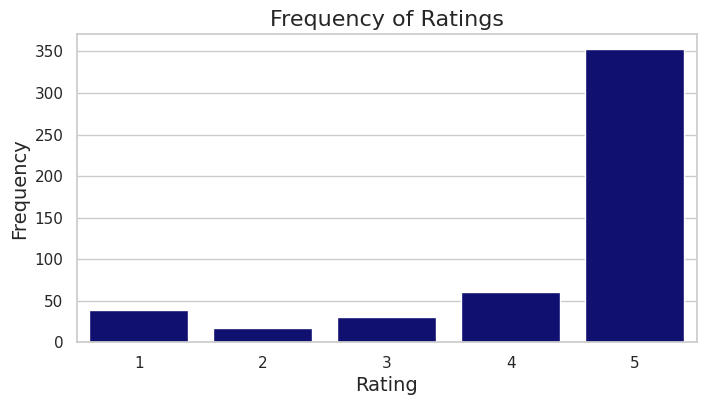

In [9]:
rating_counts = data['rating'].value_counts().sort_index()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(x=rating_counts.index, y=rating_counts.values, color='navy')
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Frequency of Ratings', fontsize=16)
plt.show()

In [10]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    70.6
4    12.2
1     7.8
3     6.0
2     3.4
Name: count, dtype: float64


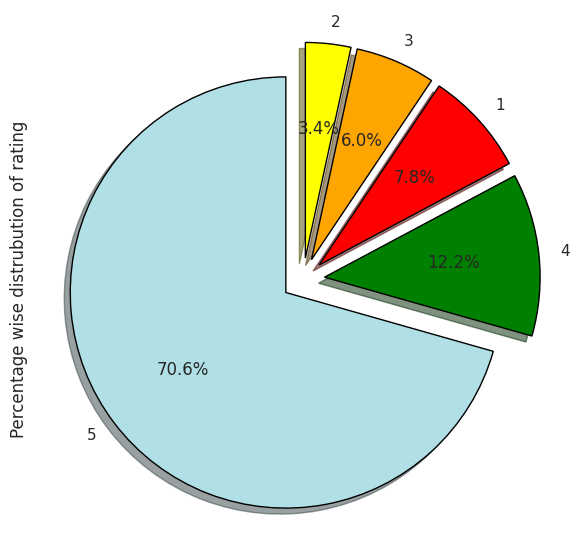

In [11]:
fig = plt.figure(figsize=(7,7))

colors = ('powderblue', 'green', 'red','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

<Figure size 1000x600 with 0 Axes>

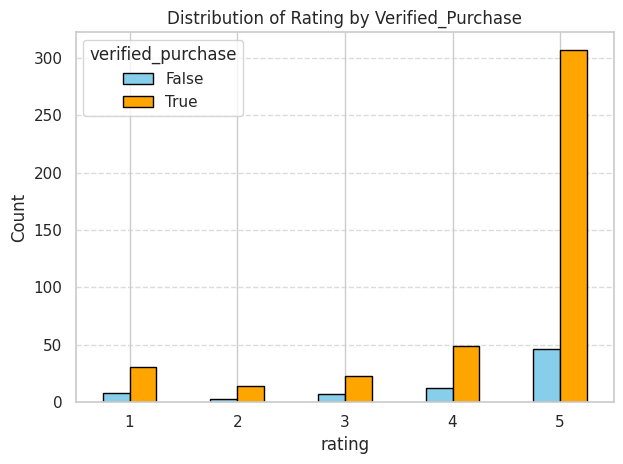

In [12]:
counts = data.groupby(['rating', 'verified_purchase']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
counts.plot(kind='bar', stacked=False, color=['skyblue', 'orange'], edgecolor='black')

# Adding labels and title
plt.title('Distribution of Rating by Verified_Purchase')
plt.xlabel('rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='verified_purchase', labels=['False', 'True'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
data['length'] = data['text'].apply(lambda x: len(x))
data.head(4)

,rating,title,text,helpful_vote,verified_purchase,length
0,2,Works flawlessly! Allows 2 unique displays wit...,UPDATE (from 5 stars to 2 stars): JAN 2023: On...,0,False,1258
1,2,"Doesn't support 2 displays, even for Intel Macs",I am quite disappointed in this dock. It had l...,0,False,541
2,5,"Laptop Computer, 15.6"" , 8th Gen Intel Core i5...",I've been using this the last 6 weeks and it h...,15,False,1587
3,2,Inspiron i17RV-9909BLK 17.3-Inch Ultrabook 1.8...,I loved it until it died yesterday. I got this...,0,True,441


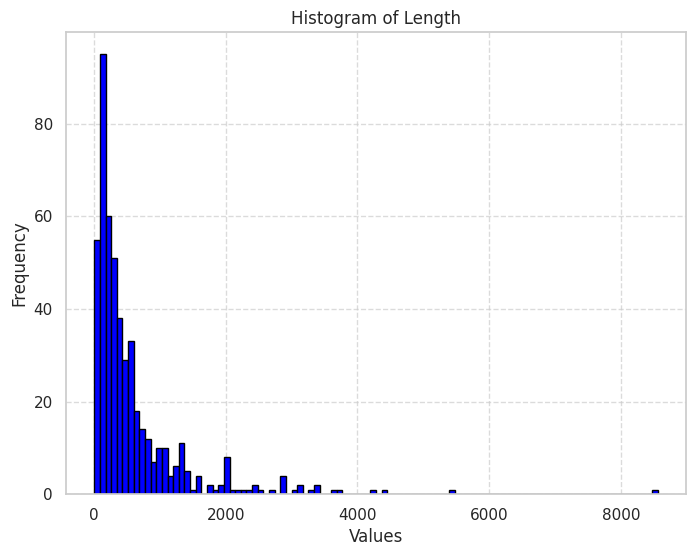

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(data['length'], bins=100, edgecolor='black', color='blue')
plt.title('Histogram of Length')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [15]:
print(f"'verified_reviews' column value: {data.iloc[10]['text']}") 
print(f"Length of review : {len(data.iloc[10]['text'])}") 
print(f"'length' column value : {data.iloc[10]['length']}")

'verified_reviews' column value: Works well in both bands and with Bluetooth.  Works with both intel and amd processors contrary to description. Upgraded from an older i5 to a ryzen 5 and it worked with both with no issues.
Length of review : 190
'length' column value : 190


In [16]:
print(f"Feedback value count: \n{data['verified_purchase'].value_counts()}")

Feedback value count: 
verified_purchase
True     424
False     76
Name: count, dtype: int64


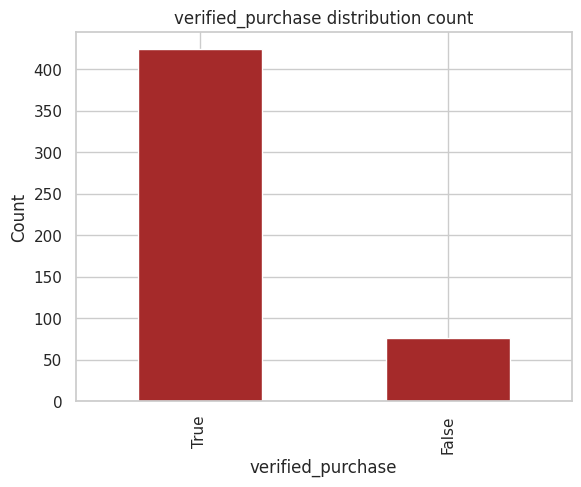

In [17]:
data['verified_purchase'].value_counts().plot.bar(color = 'brown')
plt.title('verified_purchase distribution count')
plt.xlabel('verified_purchase')
plt.ylabel('Count')
plt.show()

In [18]:
review_0 = data[data['verified_purchase'] == True].iloc[1]['text']
print(review_0)

Easy to set up and use. Great for hands free. Love to set reminders, shopping lists, alarms, and listen to music. Very happy with my new Alexa device.


In [19]:
review_1 = data[data['verified_purchase'] == False].iloc[1]['text']
print(review_1)

I am quite disappointed in this dock. It had lots of positive reviews, but for my Intel (not M1/M2) Macbook Pro (2018), it only lets you output to 1 unique monitor (if you have more than 1 monitor plugged in, they will all show the same thing), even if your laptop lid is closed.<br /><br />The description said that for M1/M2 Macs, all the external monitors would show the same thing. But this is apparently the case for Intel Macs as well.<br /><br />Would NOT recommend if you have an Intel Mac and want to use 2 unique external monitors.


In [20]:
data[data['verified_purchase'] == True]['rating'].value_counts()

rating
5    307
4     49
1     31
3     23
2     14
Name: count, dtype: int64

In [21]:
data[data['verified_purchase'] == False]['rating'].value_counts()

rating
5    46
4    12
1     8
3     7
2     3
Name: count, dtype: int64

In [22]:
#analysisng text reviews column
data['length'].describe()

count     500.000000
mean      591.906000
std       803.071227
min         5.000000
25%       147.000000
50%       329.000000
75%       671.250000
max      8563.000000
Name: length, dtype: float64

# VADER Sentiment Analysis

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment analysis tool specifically designed to handle social media text. It is a lexicon and rule-based model that is particularly effective at analyzing the sentiment of short texts and social media posts.

### Key Features:
- **Lexicon-Based**: VADER uses a predefined list of words, each associated with a sentiment score. These scores range from -4 (most negative) to +4 (most positive).
- **Sensitive to Punctuation**: VADER considers the impact of punctuation such as exclamation marks and capitalization, which can amplify sentiment.
- **Handles Slang and Emojis**: It is capable of interpreting internet slang and emoticons, making it highly suitable for analyzing social media content.
- **Efficient**: VADER is computationally efficient and can be easily integrated into Python projects.

### Example Usage:
VADER is commonly used to determine whether a given piece of text is positive, negative, or neutral. This makes it a valuable tool for analyzing customer reviews, social media comments, and other forms of user-generated content.

By using VADER in your sentiment analysis, you can leverage its strengths in handling informal and concise language typically found in online reviews and social media posts.

In [23]:
data['Id'] = range(1, len(data) + 1)
data.head()

,rating,title,text,helpful_vote,verified_purchase,length,Id
0,2,Works flawlessly! Allows 2 unique displays wit...,UPDATE (from 5 stars to 2 stars): JAN 2023: On...,0,False,1258,1
1,2,"Doesn't support 2 displays, even for Intel Macs",I am quite disappointed in this dock. It had l...,0,False,541,2
2,5,"Laptop Computer, 15.6"" , 8th Gen Intel Core i5...",I've been using this the last 6 weeks and it h...,15,False,1587,3
3,2,Inspiron i17RV-9909BLK 17.3-Inch Ultrabook 1.8...,I loved it until it died yesterday. I got this...,0,True,441,4
4,5,Such an intelligent watch! Incredible!,My wife loves this Amazfit Bip Pro 3 Smart Wat...,2,False,1279,5


In [24]:
example = data['text'][50]
example

'Works like a charm!  Does not provide power to chip.  I can program via Arduino IDE is using avrdude via terminal on my Mac.  Setting fuses is easy, clearing EEPRON, etc.  very nice little unit!<br /><br />To lick (protect) chip, set lick fuses to 0x0C after programming.'

In [25]:
sia = SentimentIntensityAnalyzer()

In [26]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'compound': 0.8951}

In [27]:
#Run the polarity score on the ebtire dataset
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
vaders = pd.DataFrame(res).T
vaders

,neg,neu,pos,compound
1,0.027,0.880,0.093,0.9484
2,0.022,0.909,0.069,0.5864
3,0.012,0.884,0.104,0.9776
4,0.141,0.768,0.091,-0.5106
5,0.051,0.771,0.178,0.9877
...,...,...,...,...
496,0.000,0.408,0.592,0.8910
497,0.000,0.748,0.252,0.7500
498,0.000,0.839,0.161,0.5859
499,0.000,0.848,0.152,0.7152


In [29]:
vaders = vaders.reset_index().rename(columns={'index':"Id"})
vaders = vaders.merge(data, how="left")
vaders

,Id,neg,neu,pos,compound,rating,title,text,helpful_vote,verified_purchase,length
0,1,0.027,0.880,0.093,0.9484,2,Works flawlessly! Allows 2 unique displays wit...,UPDATE (from 5 stars to 2 stars): JAN 2023: On...,0,False,1258
1,2,0.022,0.909,0.069,0.5864,2,"Doesn't support 2 displays, even for Intel Macs",I am quite disappointed in this dock. It had l...,0,False,541
2,3,0.012,0.884,0.104,0.9776,5,"Laptop Computer, 15.6"" , 8th Gen Intel Core i5...",I've been using this the last 6 weeks and it h...,15,False,1587
3,4,0.141,0.768,0.091,-0.5106,2,Inspiron i17RV-9909BLK 17.3-Inch Ultrabook 1.8...,I loved it until it died yesterday. I got this...,0,True,441
4,5,0.051,0.771,0.178,0.9877,5,Such an intelligent watch! Incredible!,My wife loves this Amazfit Bip Pro 3 Smart Wat...,2,False,1279
...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.000,0.408,0.592,0.8910,5,"No more $$, HOT running Intel CPUs for me.",Stable as a rock. Temps good. Fast. Included c...,0,True,74
496,497,0.000,0.748,0.252,0.7500,5,Works Great in Intel NUC,This laptop memory was quickly shipped via sma...,0,True,145
497,498,0.000,0.839,0.161,0.5859,1,I later purchased a Fosmon HD1832 Intelligent ...,Did not work properly. The video didn't sync c...,1,True,183
498,499,0.000,0.848,0.152,0.7152,3,No longer supported by intel,If you want up to date drivers don't buy this....,3,True,242


Text(0.5, 1.0, 'Compound Score by Star Reviews')

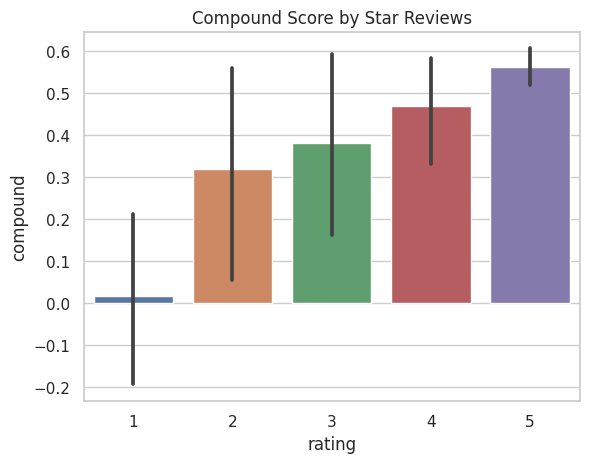

In [30]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title("Compound Score by Star Reviews")

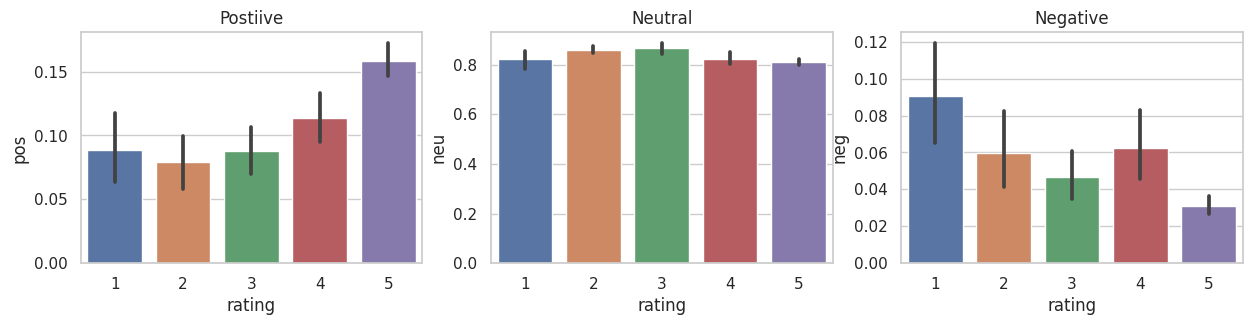

In [31]:
fig, axs = plt.subplots(1,3, figsize=(15,3))
sns.barplot(data=vaders, x = "rating", y="pos", ax=axs[0])
sns.barplot(data=vaders, x = "rating", y="neu", ax=axs[1])
sns.barplot(data=vaders, x = "rating", y="neg", ax=axs[2])

axs[0].set_title("Postiive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")

plt.tight_layout
plt.show()

# RoBERTa Model

RoBERTa (A Robustly Optimized BERT Pretraining Approach) is an advanced variant of the BERT (Bidirectional Encoder Representations from Transformers) model. Developed by Facebook AI, RoBERTa improves upon BERT by optimizing its pretraining methodology, resulting in enhanced performance on various natural language processing (NLP) tasks.

### Key Features:
- **Enhanced Pretraining**: RoBERTa modifies BERT’s pretraining approach by training on larger datasets, using larger batch sizes, and extending the training duration. It also removes the next sentence prediction task used in BERT, focusing solely on the masked language model (MLM) objective.
- **Larger Training Corpus**: It is pretrained on a diverse set of text corpora, including the Common Crawl news dataset, OpenWebText, Stories, and Wikipedia, leading to a more robust understanding of language.
- **Dynamic Masking**: Instead of static masking, RoBERTa dynamically changes the masking pattern applied to the training data, enhancing the model's ability to generalize.
- **Improved Performance**: RoBERTa achieves state-of-the-art performance on several NLP benchmarks, outperforming BERT and other models in tasks like sentiment analysis, text classification, and question answering.

### Example Usage:
RoBERTa is widely used for various NLP tasks, including sentiment analysis, where it can classify text as positive, negative, or neutral. Its advanced pretraining allows it to capture subtle nuances and context in text, making it a powerful tool for analyzing complex language patterns.

By incorporating RoBERTa into your sentiment analysis, you can leverage its sophisticated understanding of language to obtain more accurate and nuanced sentiment predictions.

In [32]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [33]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores

array([0.01183225, 0.07509217, 0.91307557], dtype=float32)

In [34]:

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output.logits[0].detach().numpy()
scores = softmax(scores)
scores_dict = {
        'roberta_negative': scores[0],
        'roberta_neutral': scores[1],
        'roberta_positive': scores[2]
}
print(scores_dict)

{'roberta_negative': 0.011832246, 'roberta_neutral': 0.07509217, 'roberta_positive': 0.91307557}


In [35]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_negative': scores[0],
        'roberta_neutral': scores[1],
        'roberta_positive': scores[2]
    }
    
    return scores_dict
    

In [36]:
#Run the polarity score on the ebtire dataset
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['text']
    myid = row['Id']
    vader_result = sia.polarity_scores(text)
    roberta_result = polarity_scores_roberta(text)
    break
    
print(f' Roberta Model Result {roberta_result}')
print(f' Vader Model {vader_result}')

  0%|          | 0/500 [00:00<?, ?it/s]

 Roberta Model Result {'roberta_negative': 0.06366372, 'roberta_neutral': 0.14886272, 'roberta_positive': 0.78747356}
 Vader Model {'neg': 0.027, 'neu': 0.88, 'pos': 0.093, 'compound': 0.9484}


In [37]:
both = {**vader_result, **roberta_result}
both

{'neg': 0.027,
 'neu': 0.88,
 'pos': 0.093,
 'compound': 0.9484,
 'roberta_negative': 0.06366372,
 'roberta_neutral': 0.14886272,
 'roberta_positive': 0.78747356}

In [38]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        pass  

  0%|          | 0/500 [00:00<?, ?it/s]

In [39]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index':'Id'})
results_df = results_df.merge(data, how='left')

In [40]:
results_df

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_negative,roberta_neutral,roberta_positive,rating,title,text,helpful_vote,verified_purchase,length
0,1,0.027,0.880,0.093,0.9484,0.063664,0.148863,0.787474,2,Works flawlessly! Allows 2 unique displays wit...,UPDATE (from 5 stars to 2 stars): JAN 2023: On...,0,False,1258
1,2,0.022,0.909,0.069,0.5864,0.766329,0.205386,0.028285,2,"Doesn't support 2 displays, even for Intel Macs",I am quite disappointed in this dock. It had l...,0,False,541
2,3,0.012,0.884,0.104,0.9776,0.018883,0.114449,0.866668,5,"Laptop Computer, 15.6"" , 8th Gen Intel Core i5...",I've been using this the last 6 weeks and it h...,15,False,1587
3,4,0.141,0.768,0.091,-0.5106,0.431541,0.343271,0.225189,2,Inspiron i17RV-9909BLK 17.3-Inch Ultrabook 1.8...,I loved it until it died yesterday. I got this...,0,True,441
4,5,0.051,0.771,0.178,0.9877,0.002016,0.017065,0.980919,5,Such an intelligent watch! Incredible!,My wife loves this Amazfit Bip Pro 3 Smart Wat...,2,False,1279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,496,0.000,0.408,0.592,0.8910,0.003342,0.049535,0.947123,5,"No more $$, HOT running Intel CPUs for me.",Stable as a rock. Temps good. Fast. Included c...,0,True,74
471,497,0.000,0.748,0.252,0.7500,0.001704,0.038476,0.959820,5,Works Great in Intel NUC,This laptop memory was quickly shipped via sma...,0,True,145
472,498,0.000,0.839,0.161,0.5859,0.410713,0.420489,0.168798,1,I later purchased a Fosmon HD1832 Intelligent ...,Did not work properly. The video didn't sync c...,1,True,183
473,499,0.000,0.848,0.152,0.7152,0.852296,0.132878,0.014826,3,No longer supported by intel,If you want up to date drivers don't buy this....,3,True,242


In [41]:
results_data = results_df.copy()

In [42]:
#A function to update the vader predict column based on vader_compound value

def update_vader_predict(row):
    compound_score = row['vader_compound']
    
    if compound_score > 0.9:
        return 'Positive'
    elif compound_score > 0.6:
        return 'Positive'
    elif compound_score > 0.3:
        return 'Positive'
    elif compound_score > 0.05:
        return 'Positive'
    elif compound_score >= -0.05:
        return 'Neutral'
    elif compound_score >= -0.3:
        return 'Negative'
    elif compound_score >= -0.6:
        return 'Negative'
    elif compound_score >= -0.9:
        return 'Negative'
    else:
        return 'Negative'

#Define a function to determine the highest sentiment for the roberta columns
    
def determine_roberta_sentiment(row):
    if row["roberta_positive"] > row['roberta_negative'] and row['roberta_positive'] > row['roberta_neutral']:
        return "Postive"
    elif row["roberta_negative"] > row['roberta_positive'] and row['roberta_negative'] > row['roberta_neutral']:
        return "Negative"
    else:
        return "Neutral"

results_data['vader_sentiment'] = results_data.apply(update_vader_predict, axis=1)
results_data['roberta_predict'] = results_data.apply(determine_roberta_sentiment, axis=1)

In [43]:
pivot_table = results_data.pivot_table(index='rating', columns='vader_sentiment', values='Id', aggfunc='count', fill_value=0)
print(pivot_table)

vader_sentiment  Negative  Neutral  Positive
rating                                      
1                      17        3        19
2                       5        0        12
3                       8        2        16
4                      10        3        40
5                      29       33       278


In [44]:
pivot_table = results_data.pivot_table(index='rating', columns='roberta_predict', values='Id', aggfunc='count', fill_value=0)
print(pivot_table)

roberta_predict  Negative  Neutral  Postive
rating                                     
1                      30        9        0
2                      11        3        3
3                      13        9        4
4                       9       18       26
5                       7       58      275


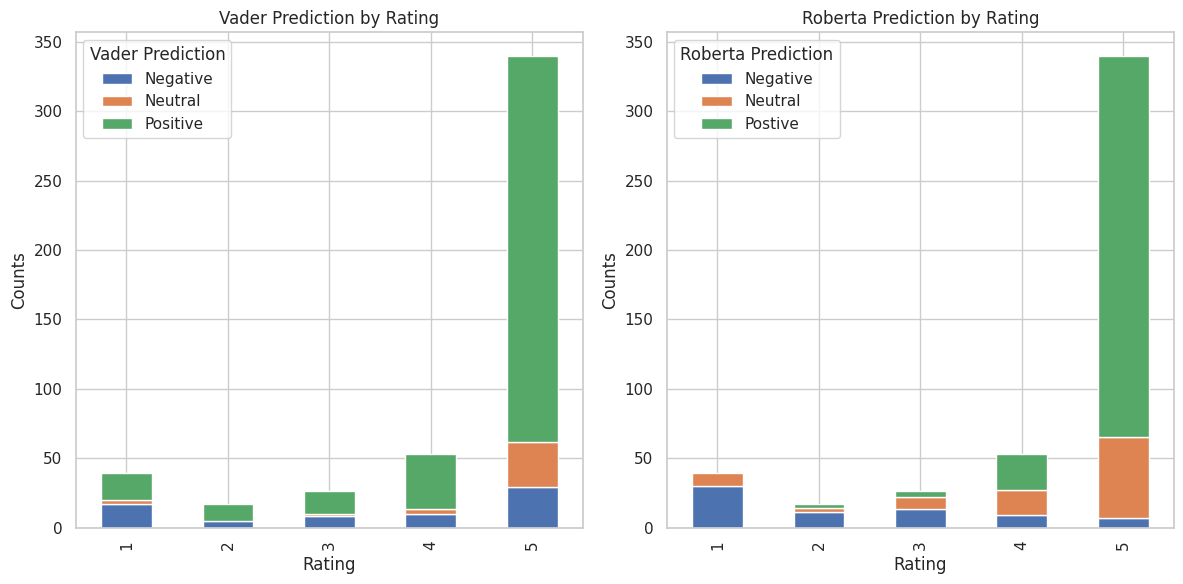

In [45]:
vader_prediction_counts  = results_data.groupby(['rating', 'vader_sentiment']).size().unstack(fill_value=0)
roberta_prediction_counts  = results_data.groupby(['rating', 'roberta_predict']).size().unstack(fill_value=0)

# Assuming axs is defined somewhere in your code
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting Vader Prediction by Rating
vader_prediction_counts.plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_title("Vader Prediction by Rating")
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Counts')
axs[0].legend(title="Vader Prediction")

# Plotting Roberta Prediction by Rating
roberta_prediction_counts.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title("Roberta Prediction by Rating")
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Counts')
axs[1].legend(title="Roberta Prediction")

plt.tight_layout()
plt.show()


In [46]:
results_data.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_negative,roberta_neutral,roberta_positive,rating,title,text,helpful_vote,verified_purchase,length,vader_sentiment,roberta_predict
0,1,0.027,0.880,0.093,0.9484,0.063664,0.148863,0.787474,2,Works flawlessly! Allows 2 unique displays wit...,UPDATE (from 5 stars to 2 stars): JAN 2023: On...,0,False,1258,Positive,Postive
1,2,0.022,0.909,0.069,0.5864,0.766329,0.205386,0.028285,2,"Doesn't support 2 displays, even for Intel Macs",I am quite disappointed in this dock. It had l...,0,False,541,Positive,Negative
2,3,0.012,0.884,0.104,0.9776,0.018883,0.114449,0.866668,5,"Laptop Computer, 15.6"" , 8th Gen Intel Core i5...",I've been using this the last 6 weeks and it h...,15,False,1587,Positive,Postive
3,4,0.141,0.768,0.091,-0.5106,0.431541,0.343271,0.225189,2,Inspiron i17RV-9909BLK 17.3-Inch Ultrabook 1.8...,I loved it until it died yesterday. I got this...,0,True,441,Negative,Negative
4,5,0.051,0.771,0.178,0.9877,0.002016,0.017065,0.980919,5,Such an intelligent watch! Incredible!,My wife loves this Amazfit Bip Pro 3 Smart Wat...,2,False,1279,Positive,Postive


In [47]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(results_data.text)

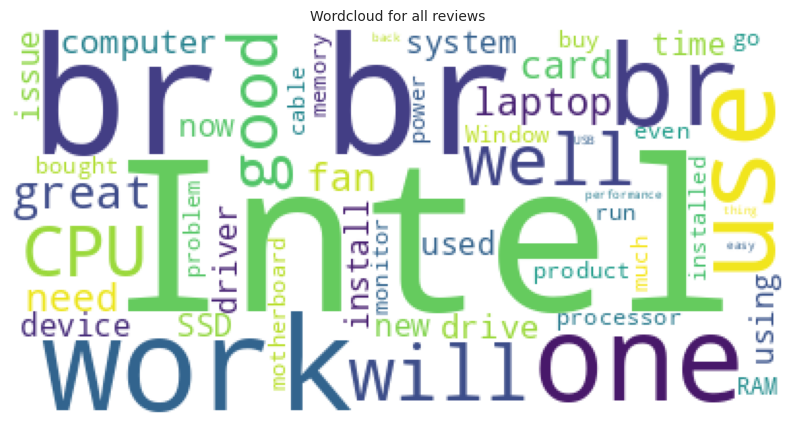

In [48]:
# Combine all reviews
reviews = " ".join([review for review in results_data['text']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [49]:
# Combine all reviews for each feedback category and split them into individual words

pos_reviews = " ".join([review for review in results_data[results_data['roberta_predict'] == 'Positive']['text']])
pos_reviews = pos_reviews.lower().split()

neu_reviews = " ".join([review for review in results_data[results_data['roberta_predict'] == 'Neutral']['text']])
neu_reviews = neu_reviews.lower().split()

neg_reviews = " ".join([review for review in results_data[results_data['roberta_predict'] == 'Negative']['text']])
neg_reviews = neg_reviews.lower().split()

# Finding words from reviews which are present in that feedback category only

unique_positive = [x for x in pos_reviews if x not in neg_reviews and x not in neu_reviews]
unique_positive = " ".join(unique_positive)

unique_neutral = [x for x in neu_reviews if x not in pos_reviews and x not in neg_reviews]
unique_neutral = " ".join(unique_neutral)

unique_negative = [x for x in neg_reviews if x not in pos_reviews and x not in neu_reviews]
unique_negative = " ".join(unique_negative)


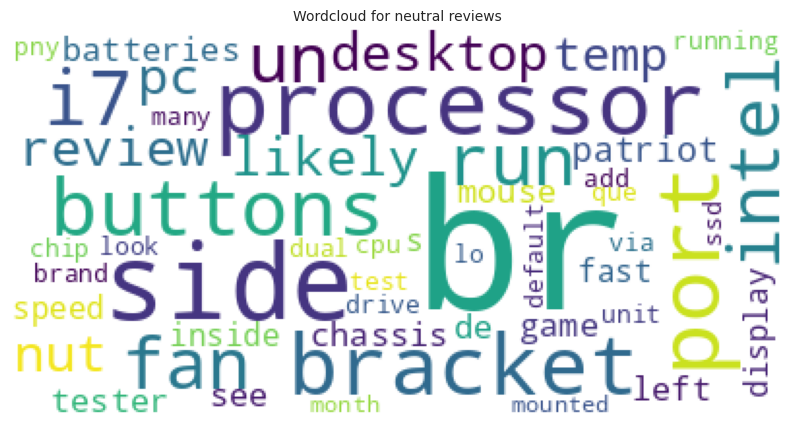

In [50]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_neutral))
plt.title('Wordcloud for neutral reviews', fontsize=10)
plt.axis('off')
plt.show()

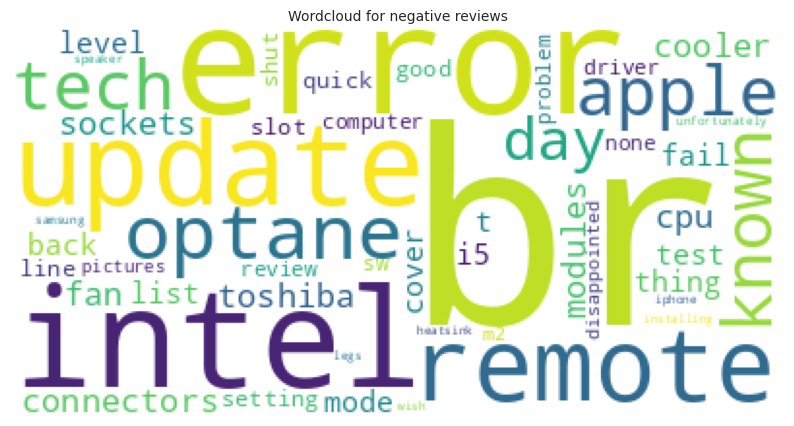

In [51]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing and Modelling
To build the corpus from the 'text' (reviews) we perform the following -

1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [52]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, results_data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', results_data.iloc[i]['text'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

### Data Balancing Code

The provided code snippet is used to balance the dataset based on the predicted sentiments from RoBERTa. 
1. **Separate Reviews by Sentiment**:
   - The dataset `results_data` is filtered to create three separate DataFrames: `negative_reviews`, `neutral_reviews`, and `positive_reviews`, each containing reviews classified as Negative, Neutral, and Positive, respectively.
   
   ```python
   negative_reviews = results_data[results_data['roberta_predict'] == 'Negative']
   neutral_reviews = results_data[results_data['roberta_predict'] == 'Neutral']
   positive_reviews = results_data[results_data['roberta_predict'] == 'Positive']


In [53]:
negative_reviews = results_data[results_data['roberta_predict'] == 'Negative']
neutral_reviews = results_data[results_data['roberta_predict'] == 'Neutral']
positive_reviews = results_data[results_data['roberta_predict'] == 'Positive']

minority_length = min(len(negative_reviews), len(neutral_reviews), len(positive_reviews))

negative_reviews_downsampled = resample(negative_reviews, replace=False, n_samples=minority_length, random_state=42)
neutral_reviews_downsampled = resample(neutral_reviews, replace=False, n_samples=minority_length, random_state=42)
positive_reviews_downsampled = resample(positive_reviews, replace=False, n_samples=minority_length, random_state=42)

balanced_data = pd.concat([negative_reviews_downsampled, neutral_reviews_downsampled, positive_reviews_downsampled])
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [54]:
cv = CountVectorizer(max_features = 200)
X = cv.fit_transform(corpus).toarray()
y = results_data['roberta_predict'].values

In [55]:
save_dir = 'Models'
os.makedirs(save_dir, exist_ok=True)

cv_path = os.path.join(save_dir, 'countVectorizer.pkl')

In [56]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [57]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (475, 200)
y shape: (475,)


## Data Balancing Pipeline

This code snippet demonstrates how to handle class imbalance in a dataset using a combination of SMOTE (Synthetic Minority Over-sampling Technique) and RandomUnderSampler within a pipeline. I have used multiple data balancing techniques because the data is highly imbalance with a more percentage of positive ratings and reviews as visualized earlier.

1. **Data Splitting**:
   - `train_test_split` splits the data `X` and labels `y` into training and testing sets with 80% of the data used for training and 20% for testing.

2. **Create Pipeline**:
   - A pipeline is created with two steps:
     - `SMOTE` to generate synthetic samples for the minority class.
     - `RandomUnderSampler` to reduce the number of samples in the majority class.
   
   ```python
   pipeline = Pipeline([
       ('smote', SMOTE(random_state=42, k_neighbors=4)),
       ('under_sampling', RandomUnderSampler(random_state=42)),
   ])


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=4)),
    ('under_sampling', RandomUnderSampler(random_state=42)),
])

# Fit the pipeline on the training data
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)


# Print shapes of datasets after balancing
print(f"X train (after balancing): {X_resampled.shape}")
print(f"y train (after balancing): {y_resampled.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")  

X train (after balancing): (738, 200)
y train (after balancing): (738,)
X test: (95, 200)
y test: (95,)


In [59]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 37
X test max value: 17


In [60]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [61]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

# Random Forest Classifier

This code snippet demonstrates how to fit a Random Forest Classifier on scaled training data.

1. **Initialize the Model**:
   - A Random Forest Classifier is instantiated using the `RandomForestClassifier()` class from `sklearn.ensemble`.
   
   ```python
   model_rf = RandomForestClassifier()


In [62]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [63]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9921052631578947
Testing Accuracy : 0.7789473684210526


In [64]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [65]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

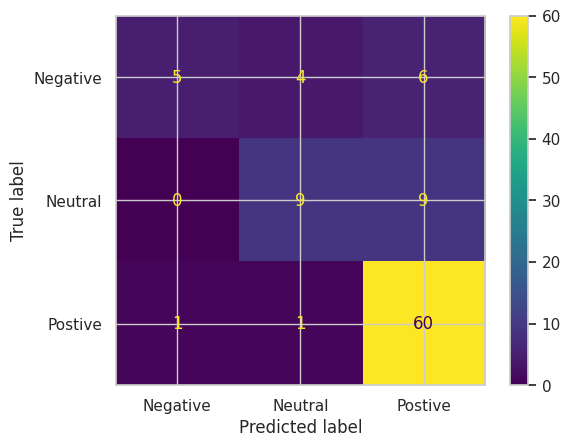

In [66]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [67]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.6736842105263158
Standard Variance : 0.033700653881225506


In [68]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [69]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [70]:
#Getting the best parameters from the grid search

print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 12, 'n_estimators': 100}


In [71]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 96.54605263157893
Cross validation mean accuracy on test set : 68.65131578947367
Accuracy score for test set : 0.7789473684210526


In [72]:
#Saving the Random Forest classifier
pickle.dump(model_rf, open('Models/model_rf.pkl', 'wb'))

# XGBoost Classifier

This code snippet demonstrates how to train an XGBoost Classifier using labeled encoded target variables.

1. **Label Encoding**:
   - `LabelEncoder` from `sklearn.preprocessing` is used to encode the categorical target variables `y_train` and `y_test`.
   
   ```python
   label_encoder = LabelEncoder()
   y_train_encoded = label_encoder.fit_transform(y_train)
   y_test_encoded = label_encoder.transform(y_test)


In [73]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train_encoded)

y_pred_train = model_xgb.predict(X_train_scl)
y_pred_test = model_xgb.predict(X_test_scl)

print("Training Accuracy:", accuracy_score(y_train_encoded, y_pred_train))
print("Testing Accuracy:", accuracy_score(y_test_encoded, y_pred_test))


Training Accuracy: 0.9894736842105263
Testing Accuracy: 0.7157894736842105


In [74]:
y_preds = model_xgb.predict(X_test)

In [75]:
cm = confusion_matrix(y_test_encoded, y_preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 8  4  3]
 [ 5  9  4]
 [ 3 17 42]]


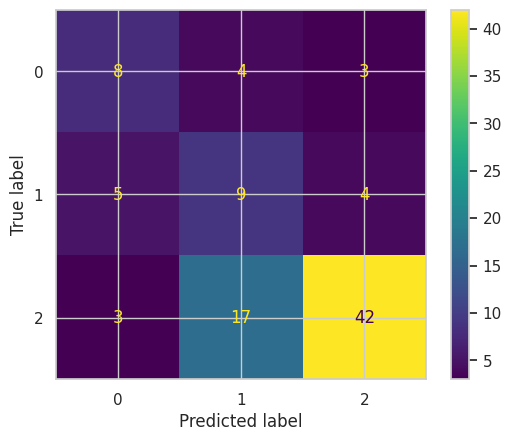

In [76]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [77]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

# Decision Tree Classifier

This code snippet demonstrates how to fit a Decision Tree Classifier on scaled training data.

1. **Initialize the Model**:
   - A Decision Tree Classifier is instantiated using the `DecisionTreeClassifier()` class from `sklearn.tree`.
   
   ```python
   model_dt = DecisionTreeClassifier()


In [78]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [79]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 0.9921052631578947
Testing Accuracy : 0.5368421052631579


In [80]:
cm = confusion_matrix(y_test_encoded, y_preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 8  4  3]
 [ 5  9  4]
 [ 3 17 42]]


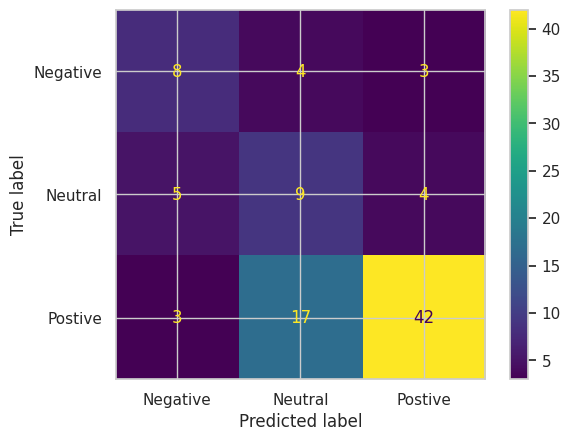

In [81]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [82]:
# Saving the Decision Tree classifier
pickle.dump(model_dt, open('Models/model_dt.pkl', 'wb'))

# SVM Classifier

This code snippet demonstrates how to train a Support Vector Machine (SVM) Classifier using labeled encoded target variables.

1. **Label Encoding**:
   - `LabelEncoder` from `sklearn.preprocessing` is used to encode the categorical target variables `y_train` and `y_test`.
   
   ```python
   from sklearn.preprocessing import LabelEncoder

   label_encoder = LabelEncoder()
   y_train_encoded = label_encoder.fit_transform(y_train)
   y_test_encoded = label_encoder.transform(y_test)


In [83]:


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Assuming X_train_scl and X_test_scl are your scaled training and testing feature matrices
model_svc = SVC(random_state=42)
model_svc.fit(X_train_scl, y_train_encoded)

y_pred_train = model_svc.predict(X_train_scl)
y_pred_test = model_svc.predict(X_test_scl)

print("Training Accuracy:", accuracy_score(y_train_encoded, y_pred_train))
print("Testing Accuracy:", accuracy_score(y_test_encoded, y_pred_test))

Training Accuracy: 0.7868421052631579
Testing Accuracy: 0.6526315789473685


In [84]:
# Saving the SVC classifier
pickle.dump(model_svc, open('Models/model_svc.pkl', 'wb'))